# Sentiment Analysis with Bert

In [199]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import transformers
from transformers import BertModel, AutoTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
#from google_play_scraper import Sort, reviews_all
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, recall_score, precision_score, f1_score
from collections import Counter
from collections import defaultdict
from textwrap import wrap
import wandb
from torch import nn
from torch.utils.data import Dataset, DataLoader
#from imblearn.over_sampling import SMOTE
from datasets import load_metric
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
import textwrap
#set global viables
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='darkgrid', palette='deep', font_scale=1.2)
rcParams['figure.figsize'] = 8, 6
#set random seed for reproduceble
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Acquisition

* In this step, I use sort and reviews_all functions from google_play_scraper to get all user reviews of Tinder on Google PlayStore. The plan is actually to scrape reviews on bothe Google PlayStore and AppStore, but with AppStore is not free to call the api. So at last, I only get reviews from PlayStore.
* The data is filtered with country Germany and language on german.

In [202]:
"""
result = reviews_all(
    'com.tinder',
    sleep_milliseconds=10,
    lang='de',
    country='de',
    sort=Sort.MOST_RELEVANT,
    filter_score_with=None
)

df = pd.DataFrame(result)
df.to_csv('reviews.csv', index=False)

"""

"\nresult = reviews_all(\n    'com.tinder',\n    sleep_milliseconds=10,\n    lang='de',\n    country='de',\n    sort=Sort.MOST_RELEVANT,\n    filter_score_with=None\n)\n\ndf = pd.DataFrame(result)\ndf.to_csv('tinder_google_reviews.csv', index=False)\n\n"

In [204]:
data = pd.read_csv("reviews.csv")

In [205]:
data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,858a7f70-c5f2-4c99-b7f2-85420ddc52be,Mr Moe,https://play-lh.googleusercontent.com/a/AAcHTt...,Tinder wurde in letzter Zeit von Version zu Ve...,1,30,14.11.0,2023-06-24 09:33:38,NaN,NaN,14.11.0
1,c578ee54-a6ce-4c92-a724-f457ea40ace8,Felix W,https://play-lh.googleusercontent.com/a/AAcHTt...,Absolute Abzocke. Holt euch bloß kein Abo. Abg...,1,4,14.10.0,2023-06-26 15:12:55,NaN,NaN,14.10.0
2,789108ed-62a7-45a4-8f79-de8b6f347dfc,Markus X,https://play-lh.googleusercontent.com/a-/AD_cM...,Die App hat sich im Laufe der Jahre verändert....,1,103,14.9.0,2023-05-31 13:00:16,NaN,NaN,14.9.0
3,680bcd15-426c-4e29-bd2a-cbbf84ee86af,Matthias K.,https://play-lh.googleusercontent.com/a/AAcHTt...,Die App ist mittlerweile richtig schlecht. Nut...,1,139,14.9.0,2023-05-22 08:16:17,NaN,NaN,14.9.0
4,489a6846-5651-4c10-9826-24e4832e6561,fromdeathtillborn,https://play-lh.googleusercontent.com/a-/AD_cM...,Nur mit Upgrade wirklich gut zu gebrauchen. Do...,1,141,14.7.0,2023-04-23 14:26:18,NaN,NaN,14.7.0


# Data Exploration

See key words of reviews with most thumbsup in PlayStore

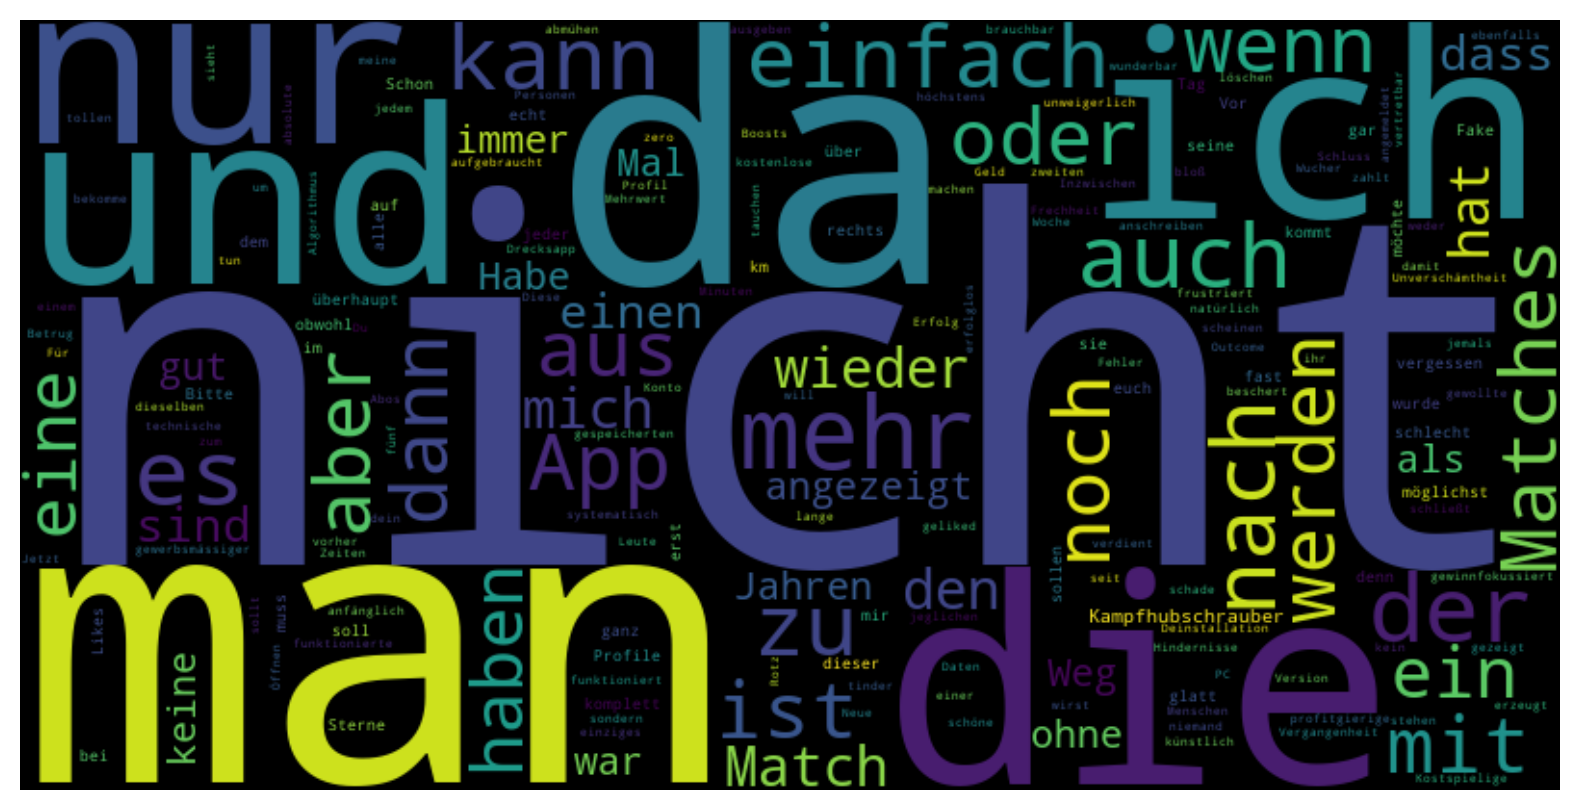

In [246]:
top_10 = data.nlargest(10, 'thumbsUpCount')
top10_reviews = top_10['content'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400).generate(top10_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

To do the further works, I will only concern review texts and score

In [206]:
# keep only useful columns for our purpose
df = data[["content","score"]]

In [207]:
df.shape

(39818, 2)

In [208]:
# checu null values
df.isnull().sum()

content    101
score        0
dtype: int64

drop null reviews

In [209]:
df = df.dropna()

In [210]:
df.shape

(39717, 2)

#### Class Distribution

In [211]:
# check distribution of review score
def plot_dis(data, x, class_names=None):
    ax = sns.countplot(data=data, x=x)

    # Add count values as annotations
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    if class_names is not None:
        ax.set_xticklabels(class_names)

    plt.show()


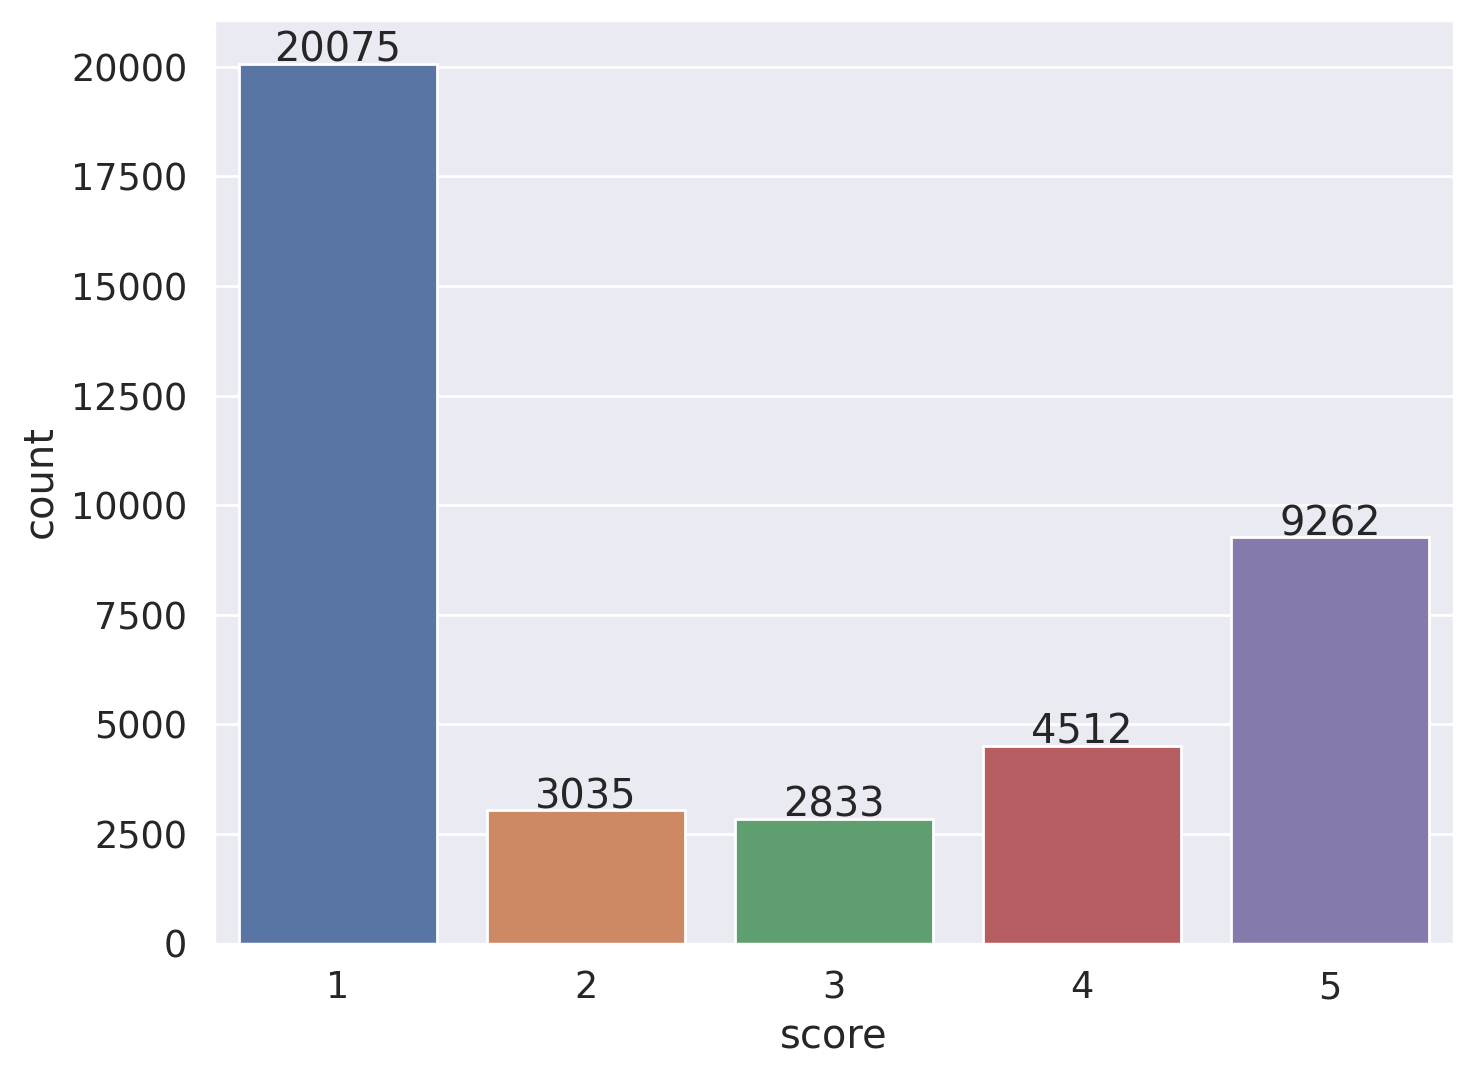

In [212]:
plot_dis(df,'score')

*Observation*:

20075 users voted 1 score, 9262 users voted 5 score. Users, which voted other scores(2/3/4) are less then 5000. Therefore, the distribution of score is imbalanced. But it doesn't really matter, because I will convert the score to only 2 parts: Negative, Positive Sentiment

#### Convert score to sentiment

In [213]:
"""
set score 1-3 to negative reviews
set score 4-5 to positive reviews

"""
def sentiment(score):
  score = int(score)
  if score <= 3:
    return 0
#   elif 1 < score <= 3:
#     return 1
  else: 
    return 1

df['sentiment'] = df.score.apply(sentiment)

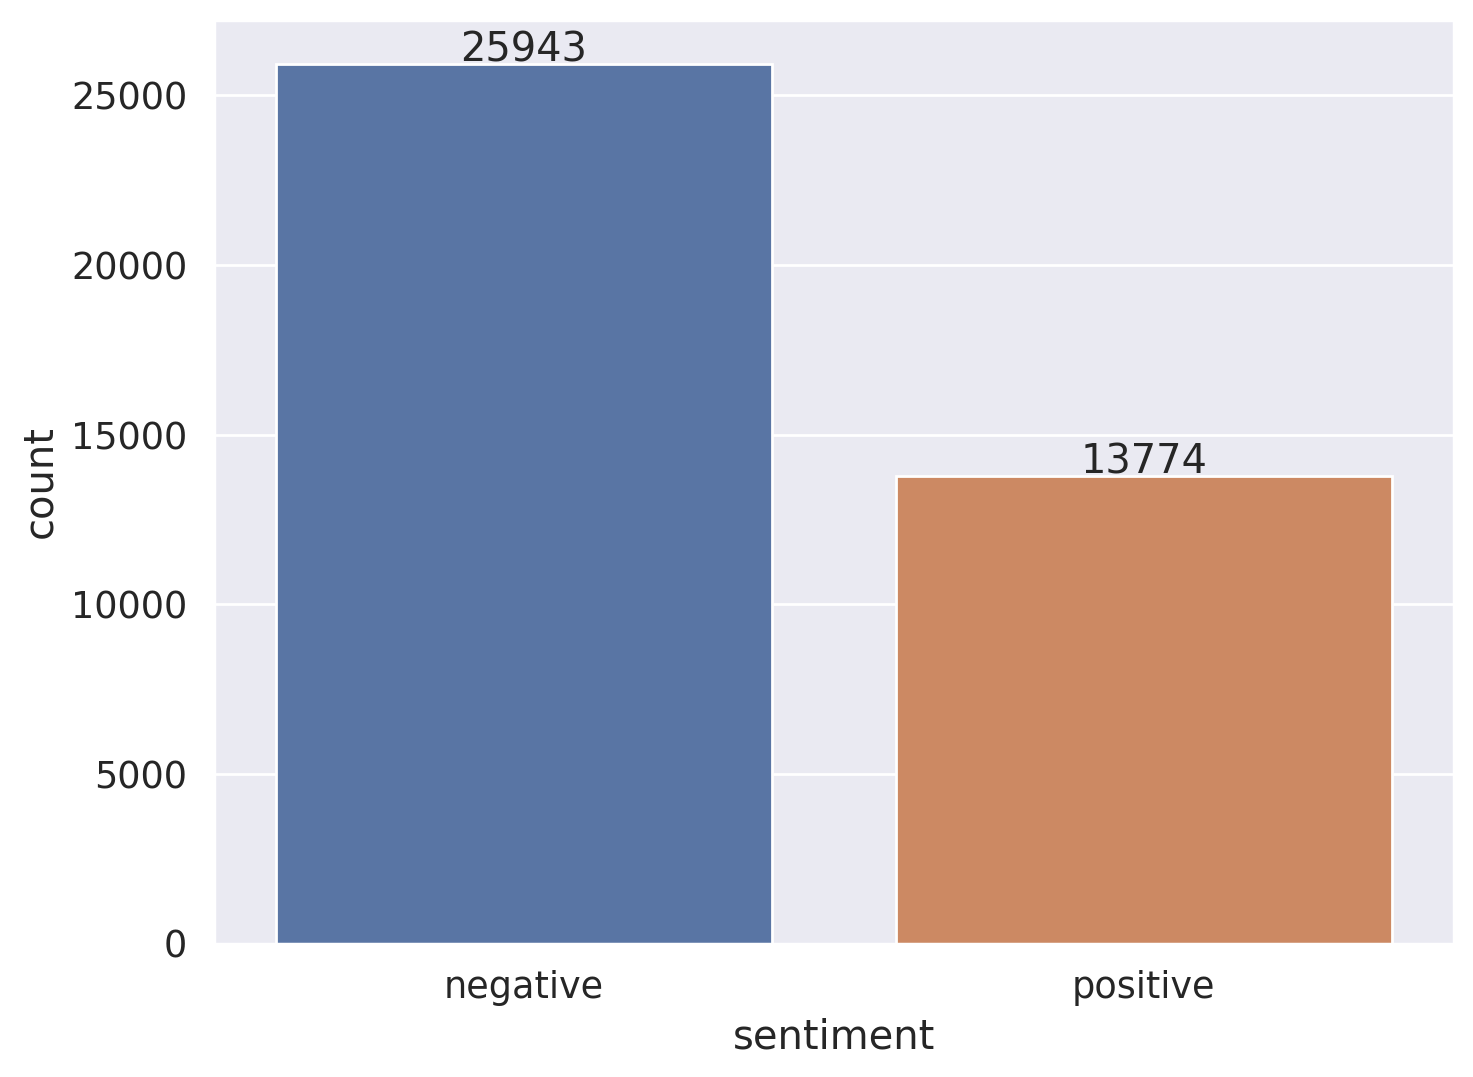

In [214]:
names = ['negative','positive']
plot_dis(df,'sentiment',names)

*Observation*:

After converting, there are 25943 negative reviews and 13774 positive reviews. The sentiment class is still imbalanced.

# Data Preprocessing

In [215]:
# score is not useful anymore
df = df [["content","sentiment"]]
df.head()

,content,sentiment
0,Tinder wurde in letzter Zeit von Version zu Ve...,0
1,Absolute Abzocke. Holt euch bloß kein Abo. Abg...,0
2,Die App hat sich im Laufe der Jahre verändert....,0
3,Die App ist mittlerweile richtig schlecht. Nut...,0
4,Nur mit Upgrade wirklich gut zu gebrauchen. Do...,0


In [216]:
pretrain_model = 'bert-base-german-cased' #use nlp model on german language

In [217]:
tokenizer = AutoTokenizer.from_pretrained(pretrain_model,no_deprecation_warning=True)

Take the 100th review as example to look how tokenizer works

In [218]:
example = df.loc[100, "content"]
print(f"\33[34mREVIEW: \33[0m'{example}'\n")
print(f"\33[34mTOKENIZED VECTOR: \33[0m{tokenizer.tokenize(example)}\n")
print(f"\33[34mTOKEN IDS: \33[0m{tokenizer.convert_tokens_to_ids(tokenizer.tokenize(example))}\n")
print(f"\33[34mENCODED VECTOR: \33[0m{tokenizer.encode(example)}\n")
print(f"\33[34mENCODED(+) VECTOR: \33[0m{tokenizer.encode_plus(example, return_tensors='pt')}")

REVIEW: 'Fake profile ohne Ende!!!!! Und es werden immer mehr... Ich bin mir auch relativ sicher das mein Profil die meiste Zeit nicht angezeigt wird! Habe wochenlang kein einziges like, ist wohl eine Masche um den Erfolg zu verhindern und den Kunden dadurch auf der App zu halten'

TOKENIZED VECTOR: ['Fa', '##ke', 'profil', '##e', 'ohne', 'Ende', '!', '!', '!', '!', '!', 'Und', 'es', 'werden', 'immer', 'mehr', '.', '.', '.', 'Ich', 'bin', 'mir', 'auch', 'relativ', 'sicher', 'das', 'mein', 'Profil', 'die', 'meist', '##e', 'Zeit', 'nicht', 'angezeigt', 'wird', '!', 'Hab', '##e', 'wo', '##chen', '##lang', 'kein', 'einziges', 'li', '##ke', ',', 'ist', 'wohl', 'eine', 'Mas', '##che', 'um', 'den', 'Erfolg', 'zu', 'verhindern', 'und', 'den', 'Kunden', 'dadurch', 'auf', 'der', 'App', 'zu', 'halten']

TOKEN IDS: [4602, 772, 25008, 26897, 935, 926, 26982, 26982, 26982, 26982, 26982, 1356, 229, 266, 922, 380, 26914, 26914, 26914, 1671, 4058, 3667, 194, 5304, 2386, 93, 3507, 14171, 30, 2734, 26897

#### Sequence Length

In [219]:
# check the length of reviews
lens = []

for content in df.content:
  tokens = tokenizer.encode(content, max_length=512)
  lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


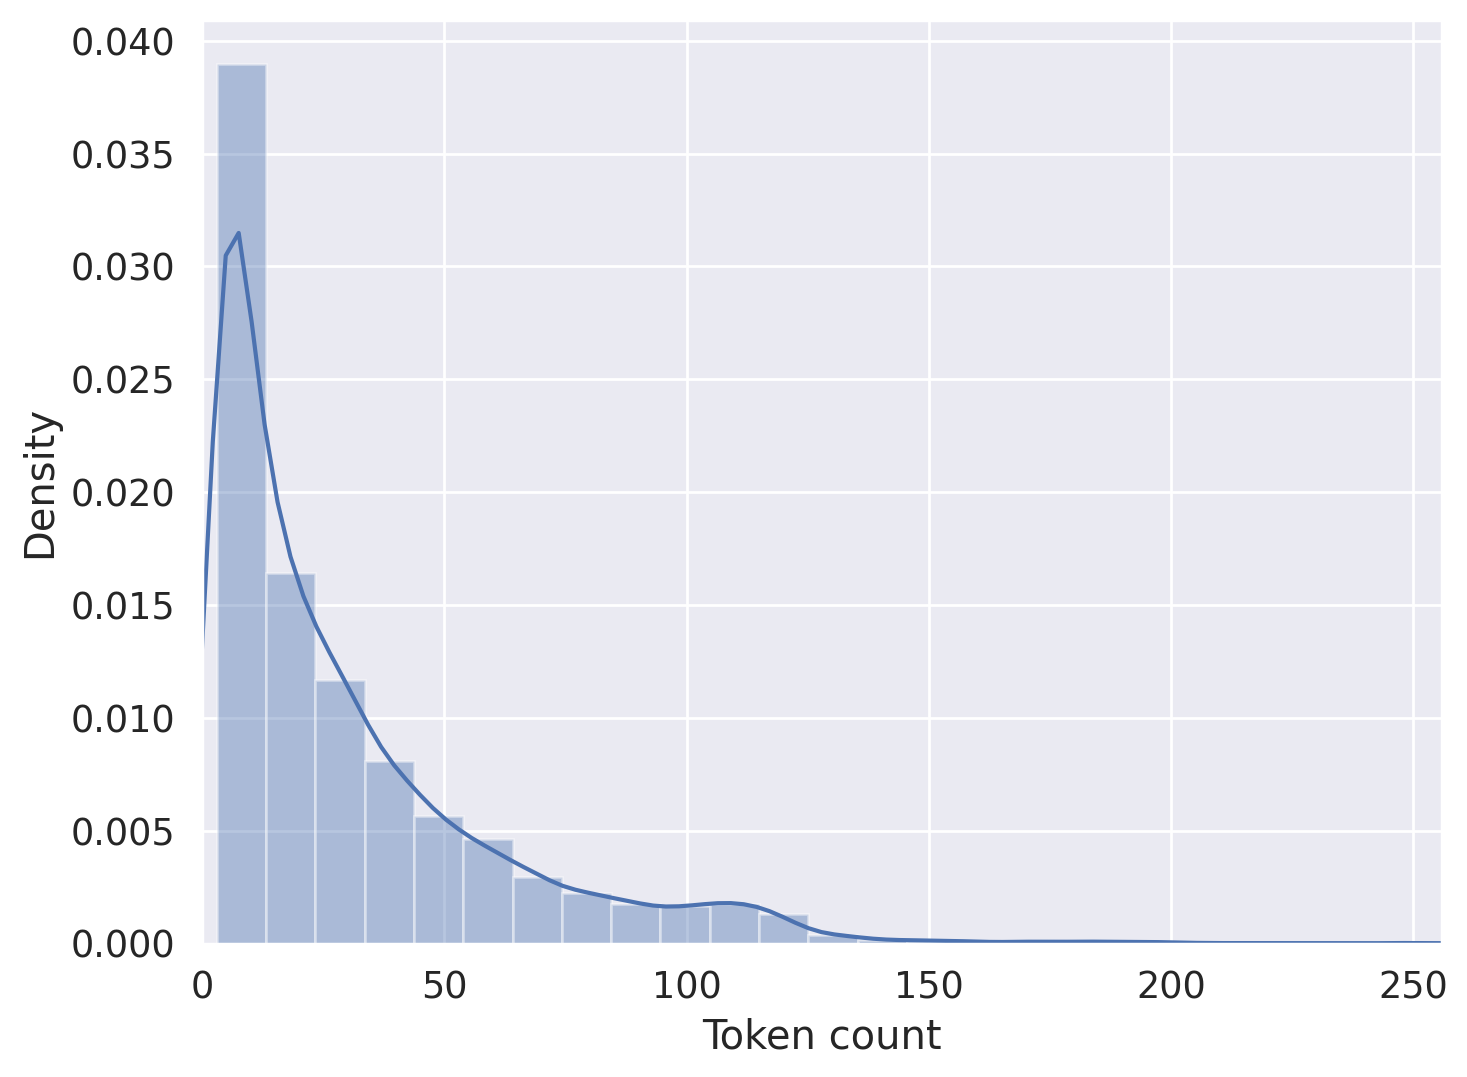

In [220]:
sns.distplot(lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

*Observation*:

Most reviews has length between 10-50, maximum till 130 token

#### Set max length and batch size

In [221]:
MAX_LEN = 130
BATCH_SIZE = 8

#### Split data into train, validation and test

In this step, I only select half size of datda, otherwise it takes about 8,5 hours to train model with full data

In [222]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((35745, 2), (1986, 2), (1986, 2))

In [223]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#### Tokenizing the dataset

In [224]:
train_encodings = tokenizer(df_train['content'].tolist(),truncation=True,padding=True,max_length=MAX_LEN)
val_encodings = tokenizer(df_val['content'].tolist(),truncation=True,padding=True,max_length=MAX_LEN)
test_encodings = tokenizer(df_test['content'].tolist(),truncation=True,padding=True,max_length=MAX_LEN)

In [225]:
"""# Perform SMOTE on the train data
smote = SMOTE()
X_train = train_encodings['input_ids']
y_train = df_train['sentiment']
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert the resampled data back to tokenized encodings
train_encodings_resampled = {
    'input_ids': X_train_resampled,
    'attention_mask': train_encodings['attention_mask'],
    'labels': y_train_resampled
}"""

"# Perform SMOTE on the train data\nsmote = SMOTE()\nX_train = train_encodings['input_ids']\ny_train = df_train['sentiment']\nX_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)\n\n# Convert the resampled data back to tokenized encodings\ntrain_encodings_resampled = {\n    'input_ids': X_train_resampled,\n    'attention_mask': train_encodings['attention_mask'],\n    'labels': y_train_resampled\n}"

In [226]:
"""class_distribution_before = Counter(y_train)
print("Sentiment distribution before resampling:")
print(class_distribution_before)
# Compute class distribution after resampling
class_distribution_after = Counter(y_train_resampled)
print("\nSentiment distribution after resampling:")
print(class_distribution_after)"""

'class_distribution_before = Counter(y_train)\nprint("Sentiment distribution before resampling:")\nprint(class_distribution_before)\n# Compute class distribution after resampling\nclass_distribution_after = Counter(y_train_resampled)\nprint("\nSentiment distribution after resampling:")\nprint(class_distribution_after)'

#### Create  Dataset class and correspoding data loaders

In [227]:
class ReviewDataset(Dataset):

  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx])
            for key, val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])

    return item

  def __len__(self):
    return len(self.labels)

In [228]:
# create dataset
train_dataset = ReviewDataset(train_encodings, df_train['sentiment'])
val_dataset = ReviewDataset(val_encodings, df_val['sentiment'])
test_dataset = ReviewDataset(test_encodings, df_test['sentiment'])

# Modeling

In [230]:
model = BertForSequenceClassification.from_pretrained('bert-base-german-cased')

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and a

In [231]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Traning model

In [233]:
model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

#### Define evaluation function

In [234]:
"""
  funtion to plot confusion matrix of model
"""
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

Instead of accuracy, I select balanced accuracy to evaluate the model due to unbalanced sentiment class distribution.

In [235]:
"""
    funtion to evaluate model with perform metrics such as balanced accuracy, precision, recall and f1 score
"""
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    balanced_accuracy = balanced_accuracy_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"balanced_accuracy": balanced_accuracy, "precision": precision, "recall": recall, "f1": f1}

#### Fine-tuning model

In [236]:
# Disable wandb logging
wandb.init(mode="disabled")

* I only train model with 1 epoch due to time problem. Also a pre-trained model has already performance on prediction, so in some case there is not necessary to fune-tuning with high epochs
* To fine-tuning model, I didn't give any optimizer because that, the Trainer will use default optimizer with AdamW.

In [237]:
args = TrainingArguments(
    report_to="none",
    output_dir='../tmp/results',
    num_train_epochs=1,
    per_device_train_batch_size=BATCH_SIZE,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset, #evaluate on validation data
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [238]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.394800
1000,0.356200
1500,0.352500
2000,0.326800
2500,0.311900
3000,0.310300
3500,0.307200
4000,0.288200


TrainOutput(global_step=4469, training_loss=0.32759699604873505, metrics={'train_runtime': 615.1696, 'train_samples_per_second': 58.106, 'train_steps_per_second': 7.265, 'total_flos': 2387964077343000.0, 'train_loss': 0.32759699604873505, 'epoch': 1.0})

#### Evaluate model

In [239]:
trainer.evaluate()

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.2536405920982361,
 'eval_balanced_accuracy': 0.8980358469539376,
 'eval_precision': 0.8712241653418124,
 'eval_recall': 0.85625,
 'eval_f1': 0.863672182821119,
 'eval_runtime': 9.6852,
 'eval_samples_per_second': 205.055,
 'eval_steps_per_second': 25.709,
 'epoch': 1.0}

*Observation*:

Based on these evaluation metrics, it seems that the model is performing well in classifying negative and positive reviews. The values for precision(0.871), recall(0.856), and f1(0.864) indicate that the model is achieving good accuracy in identifying positive reviews. The balanced_accuracy of 0.898 indicates that the model is performing well in maintaining a balance between sensitivity and specificity in its predictions.

#### Test model on test data

<class 'transformers.trainer_utils.EvalPrediction'>


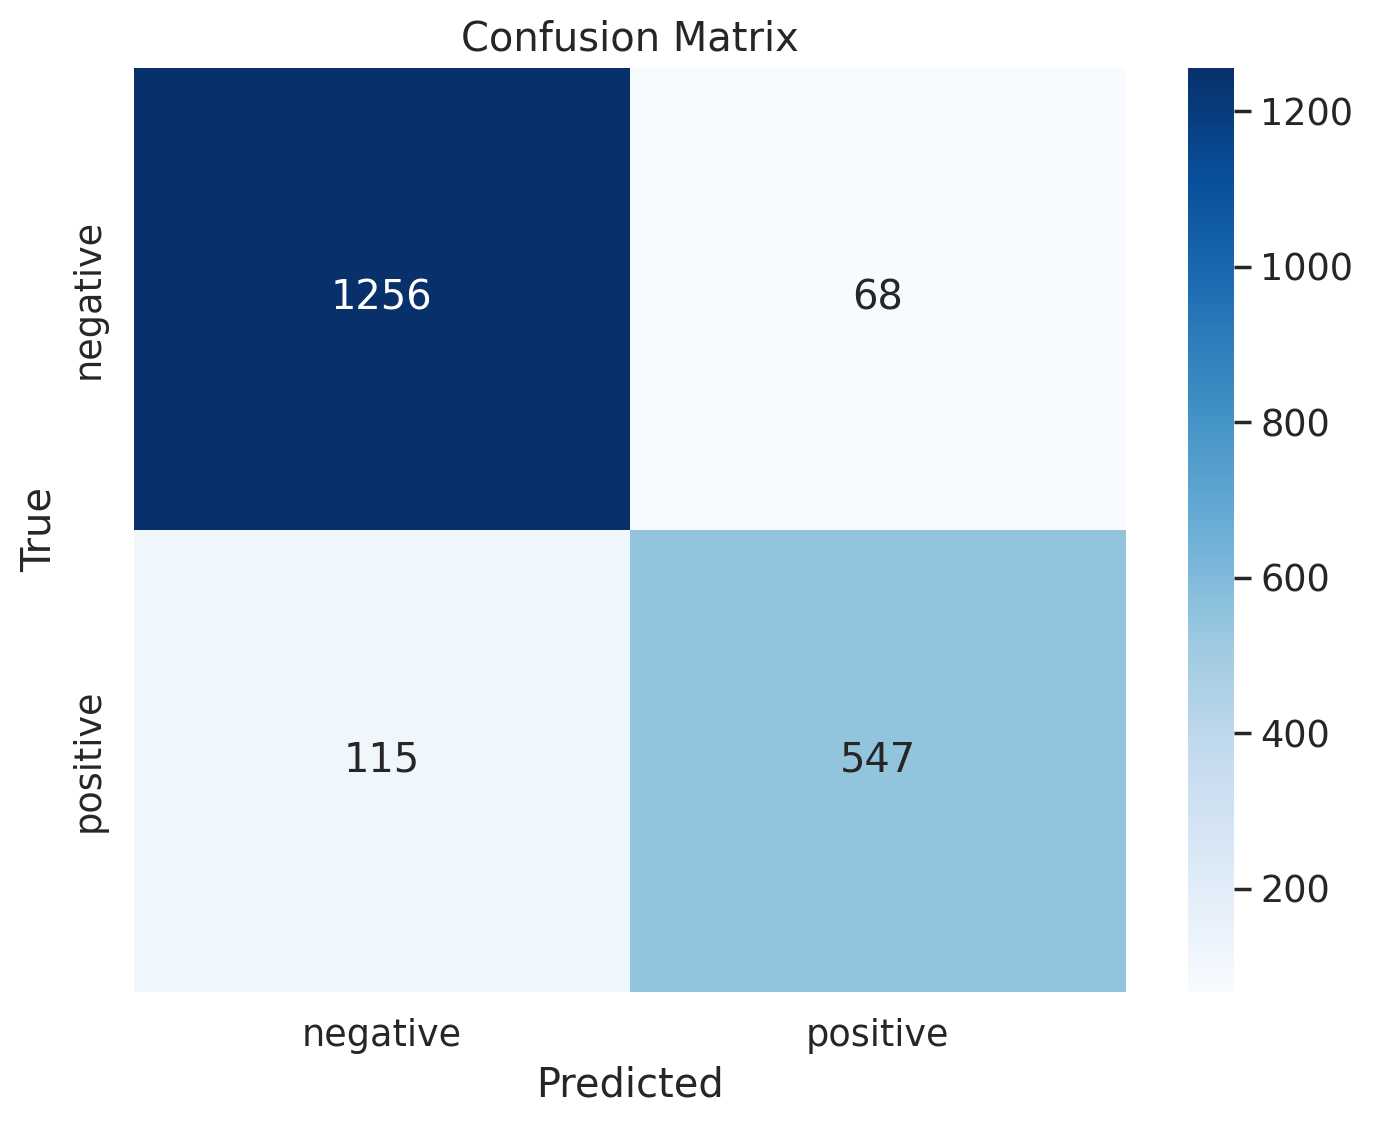

In [241]:
predictions, labels, _ = trainer.predict(test_dataset)
binary_predictions = [1 if p[1] >= 0.5 else 0 for p in predictions.tolist()]
# Compute confusion matrix
cm = confusion_matrix(labels, binary_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=names, yticklabels=names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

*Observation*:

* 1256 negative reviews are correct predicted as negative, 68 negative reviews predicted as positive
* 547 positve reviews are correct predicted as positive, 115 positive reviews predicted as negative

#### Predict a review on test data

In this step, I select the review on test data with id 12 to predict. The given result is the review itself and the predicted sentiment.

In [242]:
idx = 12  # Index of the specific prediction you want to examine

review_text = test_encodings['input_ids'][idx]  # Replace 'input_ids' with the appropriate key for the review text in your test encodings

true_sentiment = labels[idx]  # Assuming 'labels' contains the true sentiment labels
pred_probs = predictions[idx].tolist()  # Assuming 'predictions' contains the predicted probabilities

review_text_str = tokenizer.decode(review_text, skip_special_tokens=True)  # Convert the tokenized input back to a string
wrapped_review_text = textwrap.wrap(review_text_str)  # Wrap the review text

pred_df = pd.DataFrame({
    'class_names': names,
    'values': true_sentiment
})

print("\n".join(wrapped_review_text))  # Print the wrapped review text
print()
print(f"True sentiment: {names[true_sentiment]}")  # Print the true sentiment



Bilder laden nicht hoch

True sentiment: negative


### Predict raw text with model

In this step, I give some reviews by myself to model, see what it predict 

In [243]:
texts = [
"Es wäre schön, wenn das Nachrichtensystem mir tatsächlich die Antworten der Leute anzeigen würde, anstatt so zu tun, als ob sie mehrere Monate lang nicht existierten.",
"Dank der App! Ich habe hier meinen Freund kennengelernt",
"Chats verschwinden ständig. Ich kann sehen, dass ich eine Benachrichtigung habe, aber der Chat ist nicht da. Wahrscheinlich gehe ich einfach zu Bumble",
"Tinder ist einfach eine geile App"]

for text in texts:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_label = torch.argmax(predictions, dim=1).item()  # Get the index of the highest probability

    sentiment = names[predicted_label]  # Get the label from names using the predicted label as index

    print(f"Text: {text}")
    print(f"Predicted sentiment: {sentiment}")
    print()

Text: Es wäre schön, wenn das Nachrichtensystem mir tatsächlich die Antworten der Leute anzeigen würde, anstatt so zu tun, als ob sie mehrere Monate lang nicht existierten.
Predicted sentiment: negative

Text: Dank der App! Ich habe hier meinen Freund kennengelernt
Predicted sentiment: positive

Text: Chats verschwinden ständig. Ich kann sehen, dass ich eine Benachrichtigung habe, aber der Chat ist nicht da. Wahrscheinlich gehe ich einfach zu Bumble
Predicted sentiment: negative

Text: Tinder ist einfach eine geile App
Predicted sentiment: positive



# Conclusion

* Result:
    * I will say that the purpose was reached，from the evaluation and testing on raw text, the model give a good prediction on whether a review is positive or negative.
    * The data is imbalanced, so I was focus on balanced accuracy and precision, recall, f1 score. Obviously, the metrics were good

* Future work:
    * There are some other solutions to deal with data imbalanced, instead of looking the balanced accuracy, such as Undersampling / Oversampling. I did try oversampling with SMOTE to resample train data into 50% / 50% on sentiment class. But which training I always get error for "index out of range", eventhough I check the shape of datas. So in further, this might be a possible work to dive in.
    * I simply convert score to positive(with score 4 and 5) and negative(with score <=3). Another possible way is to convert score to 3 classes: negative,neutral and possitive. 
    * In addition to tuning the pre-trained model, tuning the pre-trained model first and then combining it with other deep neural network models such as CNN,RNN is also a possibility to optimize the model and get better performance.